In [11]:
from langgraph.graph import StateGraph
from typing import TypedDict, Dict, Any
from IPython.display import Image, display

In [12]:
# =========================
# STATE
# =========================
class LemonSkipState(TypedDict):
    lemons: int
    sugar: int
    water: str
    juice: str
    mix: str
    final: str
    sweet: bool
    attempts: int
    skip_water: bool
    too_sour: bool
    too_watery: bool
    forced_serve: bool

In [14]:
# =========================
# NODES
# =========================
def squeeze_lemons(state: Dict[str, Any]) -> Dict[str, Any]:
    state["juice"] = f"Juice from {state['lemons']} lemons"
    return state


def add_water(state: Dict[str, Any]) -> Dict[str, Any]:
    state["mix"] = f"{state['juice']} + {state['water']} water"
    return state


def add_sugar(state: Dict[str, Any]) -> Dict[str, Any]:
    state["sugar"] += 1
    state["attempts"] += 1
    state["mix"] = f"{state['juice']} + {state['water']} water + {state['sugar']} spoons sugar"
    return state


def taste_and_check(state: Dict[str, Any]) -> Dict[str, Any]:
    state["sweet"] = state["sugar"] >= 2

    # after first attempt, skip water forever
    if state["attempts"] >= 1:
        state["skip_water"] = True

    return state


def check_sourness(state: Dict[str, Any]) -> Dict[str, Any]:
    state["too_sour"] = state["lemons"] >= 5
    return state


def check_watery(state: Dict[str, Any]) -> Dict[str, Any]:
    state["too_watery"] = state["attempts"] >= 2
    if state["too_watery"]:
        state["skip_water"] = True
    return state


def check_patience(state: Dict[str, Any]) -> Dict[str, Any]:
    state["forced_serve"] = state["attempts"] >= 3
    return state


def serve(state: Dict[str, Any]) -> Dict[str, Any]:
    state["final"] = f"{state['mix']} → Served!"
    return state

In [15]:

# =========================
# DECISION FUNCTIONS
# =========================
def route_after_squeeze(state: Dict[str, Any]) -> str:
    return "add_sugar" if state["skip_water"] else "add_water"


def final_decision(state: Dict[str, Any]) -> str:
    if state["forced_serve"]:
        return "serve"
    if state["too_sour"]:
        return "add_sugar"
    if state["sweet"]:
        return "serve"
    return "squeeze_lemons"



In [16]:

# =========================
# BUILD GRAPH (BUILDER)
# =========================
builder = StateGraph(LemonSkipState)

# Nodes
builder.add_node("squeeze_lemons", squeeze_lemons)
builder.add_node("add_water", add_water)
builder.add_node("add_sugar", add_sugar)
builder.add_node("taste_and_check", taste_and_check)
builder.add_node("check_sourness", check_sourness)
builder.add_node("check_watery", check_watery)
builder.add_node("check_patience", check_patience)
builder.add_node("serve", serve)

# Entry
builder.set_entry_point("squeeze_lemons")

# Routing after squeeze
builder.add_conditional_edges(
    "squeeze_lemons",
    route_after_squeeze,
    {
        "add_water": "add_water",
        "add_sugar": "add_sugar",
    },
)

# Main flow
builder.add_edge("add_water", "add_sugar")
builder.add_edge("add_sugar", "taste_and_check")

# Decision chain
builder.add_edge("taste_and_check", "check_sourness")
builder.add_edge("check_sourness", "check_watery")
builder.add_edge("check_watery", "check_patience")

# Final decision
builder.add_conditional_edges(
    "check_patience",
    final_decision,
    {
        "serve": "serve",
        "add_sugar": "add_sugar",
        "squeeze_lemons": "squeeze_lemons",
    },
)

builder.set_finish_point("serve")

graph = builder.compile()

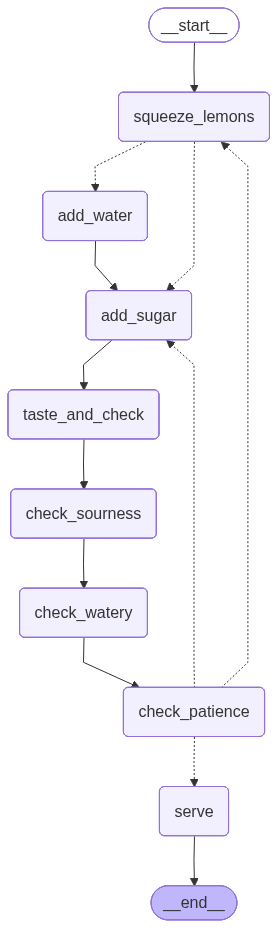

{'lemons': 4,
 'sugar': 2,
 'water': '1 glass',
 'juice': 'Juice from 4 lemons',
 'mix': 'Juice from 4 lemons + 1 glass water + 2 spoons sugar',
 'final': 'Juice from 4 lemons + 1 glass water + 2 spoons sugar → Served!',
 'sweet': True,
 'attempts': 2,
 'skip_water': True,
 'too_sour': False,
 'too_watery': True,
 'forced_serve': False}

In [17]:

# =========================
# VISUALIZE GRAPH
# =========================
display(Image(graph.get_graph().draw_mermaid_png()))


# =========================
# RUN
# =========================
initial_state = {
    "lemons": 4,
    "sugar": 0,
    "water": "1 glass",
    "juice": "",
    "mix": "",
    "final": "",
    "sweet": False,
    "attempts": 0,
    "skip_water": False,
    "too_sour": False,
    "too_watery": False,
    "forced_serve": False,
}

result = graph.invoke(initial_state)
result